This notebook examines results generated from inlScript.py

In [1]:
import os
import pickle
import BeautifulSoup

from lxml import etree
from glob import glob
from collections import Counter

import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This is the data directory where the produced pickle files from INL data set are stored.

In [3]:
DATA_DIR = '../data/'

col_eBooks = 'INL_eBook_word_counts/'
col_sanders = 'INL_Sanders_word_counts/'

For each book, we have 3 pickle files and an XML:

 - *.sem.pkl    Semanticized words
 - *.liwc.pkl   LIWC words counts
 - *.count.pkl  Paragraph lengths
 - *.xml        Contains book header data

In [4]:
endings = [ '.liwc.pkl', '.count.pkl', '.sem.pkl', '.xml' ]

In [5]:
def listBooks(DATA_DIR, collection):
    bookPaths = glob(DATA_DIR + collection + '/*')
    bookNames = []
    for path in bookPaths:
        path = path.replace(DATA_DIR, '')
        path = path.replace(collection, '')
        bookNames.append(path)
    return bookNames

In [6]:
class EchoTag(object):
    def __init__(self, targetTag):
        self.keepData = False
        self.tagData = ''
        self.targetTag = targetTag
    def start(self, tag, attrib):
        if tag==self.targetTag:
            self.keepData = True
    def end(self, tag):
        if tag=='{http://www.tei-c.org/ns/1.0}title':
            self.keepData = False
    def data(self, data):
        if self.keepData:
            self.tagData += data
    def comment(self, text):
        pass
    def close(self):
        return self.tagData

def getBookTitle(DATA_DIR, collection, book):
    xmlFile = DATA_DIR + collection + book + '/' + book + '.xml'
    parser = etree.XMLParser(target = EchoTag('{http://www.tei-c.org/ns/1.0}title'))
    try:
        docTitle = etree.parse(xmlFile, parser=parser)
    except:
        docTitle = parser.target.tagData
    return docTitle

In [7]:
def getLIWCData(DATA_DIR, collection, book):
    pklFile = DATA_DIR + collection + book + '/' + book + '.liwc.pkl'
    data = pickle.load(open(pklFile, 'r'))
    return data

def getSemanticizerData(DATA_DIR, collection, book):
    pklFile = DATA_DIR + collection + book + '/' + book + '.sem.pkl'
    data = pickle.load(open(pklFile, 'r'))
    return data

def getWordCountData(DATA_DIR, collection, book):
    pklFile = DATA_DIR + collection + book + '/' + book + '.count.pkl'
    data = pickle.load(open(pklFile, 'r'))
    return data

In [8]:
bookNames = listBooks(DATA_DIR, col_sanders)
titles_sanders = { getBookTitle(DATA_DIR, col_sanders, book): book for book in bookNames }

In [9]:
bookNames = listBooks(DATA_DIR, col_eBooks)
titles_eBooks = { getBookTitle(DATA_DIR, col_eBooks, book): book for book in bookNames }

In [10]:
book = '1991_Zonneveld, Peter van_Romantische reizen'
liwclist = getLIWCData(DATA_DIR, col_sanders, book)
semlist = getSemanticizerData(DATA_DIR, col_sanders, book)
countlist = getWordCountData(DATA_DIR, col_sanders, book)

Each pickle file contains a list where each element of the list is a tuple. Tuples have the following structure:

For tuples in the list of sematicized words:

    ( paragraph_id, anchor text, target, commonness )

Where:
- *paragraph_id* is an identifier for the paragraph
- *anchor text* is the word (or words) as it was on the book
- *target* is the title of the wikipedia page the anchor text links to
- *commonness* is the likelihood of the anchor text to be a link to the target.

E.g:

In [11]:
semlist[0]

(u'ns.isbn.9064811431.p.1', u'Romantische', u'Romantiek (stroming)', 0.5)

Next, tuples in the list of LIWC words counts:

    (paragraph_id, word, word categories))

Where:
 - *paragraph_id* is an identifier for the paragraph
 - *word* is the word as it was on the book
 - *word categories* is a list with the category (or categories) corresponding to that word

E.g:

In [13]:
liwclist[0]

(u'ns.isbn.9064811431.p.1',
 u'reizen',
 [u'Category 39, Present', u'Category 46, Motion'])

Finally, tuples in the Paragraph lengths list:

(paragraph_id, wordCount)

Where:
 - *paragraph_id* is an identifier for the paragraph
 - *wordCount* is the count of words in that paragraph

E.g:

In [12]:
countlist[0]

(u'ns.isbn.9064811431.p.1', 2)

## Exploring LIWC list

Let's create a dataframe for Paragraph, Word and Categories.

In [13]:
df = pd.DataFrame(liwclist, columns=['Paragraph', 'Word', 'Categories'])

In [14]:
df.head()

,Paragraph,Word,Categories
0,ns.isbn.9064811431.p.1,reizen,"[Category 39, Present, Category 46, Motion]"
1,ns.isbn.9064811431.p.2,van,"[Category 10, Preps]"
2,ns.isbn.9064811431.p.4,op,"[Category 42, Up, Category 10, Preps]"
3,ns.isbn.9064811431.p.4,het,"[Category 9, Article]"
4,ns.isbn.9064811431.p.5,van,"[Category 10, Preps]"


Plot of paragraph sizes

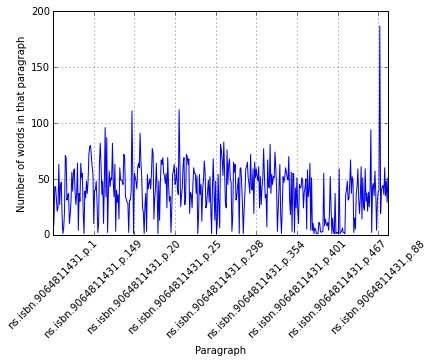

In [15]:
df.groupby('Paragraph').size().plot()
ylabel('Number of words in that paragraph')
xticks(rotation=45);

Names of categories and number in how many paragraphs the category occurs.

In [16]:
cats = {}
for i,row in df.iterrows():
    for cat in row['Categories']:
        if cat not in cats:
            cats[cat] = []
        cats[cat].append(row['Paragraph'])


In [17]:
for cat in cats:
    print cat, len(cats[cat])

Category 57, Metaph 104
Category 64, Sleep 29
Category 29, Hear 85
Category 14, Posfeel 72
Category 50, Achieve 61
Category 36, Humans 59
Category 61, Body 134
Category 34, Friends 59
Category 39, Present 1706
Category 60, Physcal 215
Category 42, Up 327
Category 33, Othref 1125
Category 38, Past 1618
Category 16, Negemo 322
Category 54, TV 3
Category 35, Family 115
Category 45, Excl 816
Category 32, Comm 261
Category 41, Space 514
Category 58, Relig 48
Category 18, Anger 65
Category 21, Cause 97
Category 40, Future 144
Category 55, Music 11
Category 12, Affect 666
Category 19, Sad 127
Category 62, Sexual 30
Category 59, Death 56
Category 22, Insight 325
Category 65, Groom 8
Category 51, Leisure 90
Category 8, Assent 34
Category 43, Down 31
Category 15, Optim 100
Category 26, Certain 186
Category 1, Pronoun 1355
Category 46, Motion 445
Category 11, Number 239
Category 5, You 55
Category 27, Senses 282
Category 7, Negate 285
Category 20, Cogmech 973
Category 47, Occup 184
Category 24, I

In [18]:
catList = [ (len(cats[cat]), cat) for cat in cats]
catList.sort()
catList = catList[::-1]

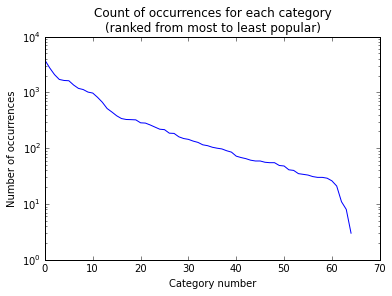

In [19]:
semilogy([c[0] for c in catList])
xlabel('Category number')
ylabel('Number of occurrences')
title('Count of occurrences for each category \n(ranked from most to least popular)')

Some categories (such as Category 12, Affect) may be more useful to look at.

Graph below shows the number of occurrences for words in this category on each paragraph

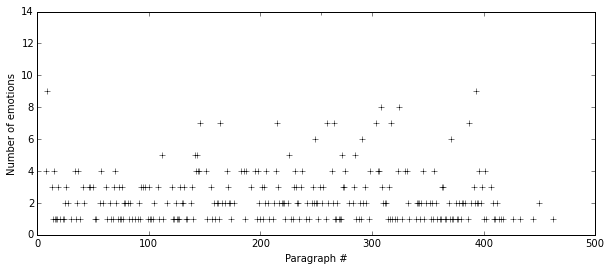

In [20]:
figure(figsize=(10,4))
countCats = Counter(cats['Category 12, Affect'])

for p in countCats:
    n = p.replace('ns.isbn.9064811431.p.', '')
    n = float(n)
    plot(n, countCats[p], '+k')
xlabel('Paragraph #')
ylabel('Number of emotions')

Identify paragraph with maximum number of occurrences of category 12: Affect (most affectionate paragraph), and look at the words in this paragraph.

In [21]:
maxParagraph = countCats.keys()[argmax(countCats.values())]

In [22]:
df1 = df[df['Paragraph']==maxParagraph]
df1[df1['Categories'].apply(lambda x: 'Category 12, Affect' in x)]

,Paragraph,Word,Categories
9513,ns.isbn.9064811431.p.254,liefhebben,"[Category 14, Posfeel, Category 39, Present, C..."
9516,ns.isbn.9064811431.p.254,geluk,"[Category 14, Posfeel, Category 12, Affect, Ca..."
9522,ns.isbn.9064811431.p.254,hopen,"[Category 39, Present, Category 12, Affect, Ca..."
9528,ns.isbn.9064811431.p.254,liefde,"[Category 14, Posfeel, Category 60, Physcal, C..."
9540,ns.isbn.9064811431.p.254,gevoel,"[Category 12, Affect, Category 27, Senses, Cat..."
9542,ns.isbn.9064811431.p.254,hemels,"[Category 57, Metaph, Category 58, Relig, Cate..."
9543,ns.isbn.9064811431.p.254,geluk,"[Category 14, Posfeel, Category 12, Affect, Ca..."
9553,ns.isbn.9064811431.p.254,gelukkig,"[Category 14, Posfeel, Category 12, Affect, Ca..."
9560,ns.isbn.9064811431.p.254,groots,"[Category 12, Affect, Category 13, Posemo]"
9582,ns.isbn.9064811431.p.254,droevig,"[Category 16, Negemo, Category 12, Affect, Cat..."


**TODO:** LIWC category clustering

Future line of research: is it possible to cluster together categories which co-ocurr most frequently? If each word is represented as a vector of categories it belongs to, it is possible to compare similarity between words.

## Exploring semanticizer list

As it can be seen, many words with low confidence have been kept. Also, many stop words and punctuation signs have been kept and should be cleaned.

In [23]:
dfsem = pd.DataFrame(semlist, columns=['Paragraph', 'Word', 'WikiTitle', 'Confidence'])
dfsem.head(15)

,Paragraph,Word,WikiTitle,Confidence
0,ns.isbn.9064811431.p.1,Romantische,Romantiek (stroming),0.500000
1,ns.isbn.9064811431.p.1,Romantische,Romantiek (muziek),0.272727
2,ns.isbn.9064811431.p.1,Romantische,Romantiek %28muziek%29,0.227273
3,ns.isbn.9064811431.p.1,reizen,Reis,0.657143
4,ns.isbn.9064811431.p.1,reizen,Reiziger (vervoer),0.171429
5,ns.isbn.9064811431.p.1,reizen,Vakantie,0.128571
6,ns.isbn.9064811431.p.2,Peter van Zonneveld,Peter van Zonneveld,1.000000
7,ns.isbn.9064811431.p.2,van,Rick Wakeman,0.333333
8,ns.isbn.9064811431.p.2,van,Bestelwagen,0.666667
9,ns.isbn.9064811431.p.2,Zonneveld,Jan Zonneveld,1.000000


In [24]:
dfsem1 = dfsem[dfsem['Paragraph']==maxParagraph]
dfsem1[dfsem1['Confidence']>0.5].head(10)

,Paragraph,Word,WikiTitle,Confidence
27713,ns.isbn.9064811431.p.254,niets,Niets,0.812500
27715,ns.isbn.9064811431.p.254,weten,Weten,1.000000
27716,ns.isbn.9064811431.p.254,niets,Niets,0.812500
27718,ns.isbn.9064811431.p.254,wensen,Wens,1.000000
27719,ns.isbn.9064811431.p.254,dan,Dan (graad),0.801802
27721,ns.isbn.9064811431.p.254,liefhebben,Liefde,1.000000
27722,ns.isbn.9064811431.p.254,vergeten,Vergeten,0.583333
27729,ns.isbn.9064811431.p.254,het,Entiteit,0.666667
27735,ns.isbn.9064811431.p.254,van,Bestelwagen,0.666667
27736,ns.isbn.9064811431.p.254,de,Duits,1.000000


# Exploring count list

In [29]:
dfcount = pd.DataFrame(countlist, columns=['Paragraph', 'Count'])
dfcount = dfcount.set_index('Paragraph')
dfcount.head(10)

,Count
Paragraph,
ns.isbn.9064811431.p.1,2
ns.isbn.9064811431.p.2,3
ns.isbn.9064811431.p.3,1
ns.isbn.9064811431.p.4,11
ns.isbn.9064811431.p.5,12
ns.isbn.9064811431.p.6,15
ns.isbn.9064811431.p.7,35
ns.isbn.9064811431.p.8,248
ns.isbn.9064811431.p.9,336


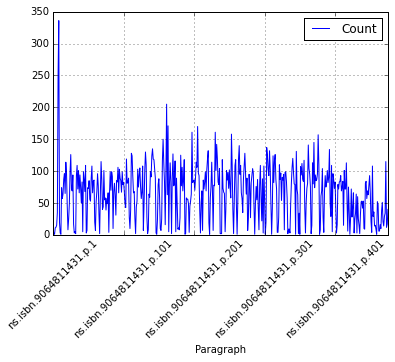

In [36]:
dfcount.plot()
xticks(rotation=45);